In [21]:
import numpy as np

In [22]:
class Perceptron(object): #パーセプトロン分類器
    
    def __init__(self, eta=0.01,n_iter=50,random_state=1):
        self.eta = eta #学習率(0.0以上1.0以下)
        self.n_iter = n_iter #訓練データの訓練回数
        self.random_state = random_state #重みを初期化するための乱数シード

    def fit(self,X,y): #訓練データに適応させる
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = 1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter): #訓練する回数分訓練データを反復
            errors = 0
            for xi, target in zip(X,y): #各訓練データで重みを重複
                update = self.eta * (target-self.predict(xi)) #重みの更新
                self.w_[1:] += update
                errors += int(update !=0.0) #重みの更新が0でない場合はご分類としてカウント
            self.errors_.append(errors) #反復ごとの誤差を格納
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:])+self.w_[0] #総入力を計算
    
    def predict(self,X): #予測メソッド
        return np.where(self.net_input(X) >=0.0, 1, -1) #1ステップあとのクラスラベルを返す


In [23]:
#irisデータセットの読み込み
import os
import pandas as pd
s = os.path.join('https://archive.ics.uci.edu','ml','machine-learning-databases','iris','iris.data')
print('URL:', s)
df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail()

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


<function matplotlib.pyplot.show(close=None, block=None)>

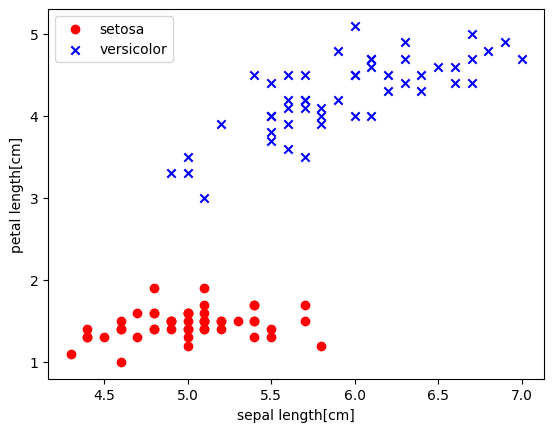

In [24]:
import matplotlib.pyplot as plt
import numpy as np

y = df.iloc[0:100, 4].values #1~100行目の目的変数の抽出
y = np.where(y == 'Iris-setosa', -1, 1) #Iris-setosaを-1,Iris-versicolorを1に変換
X = df.iloc[0:100, [0, 2]].values #1~100行目の1,3列目の抽出

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa') # 品種setosaを赤でプロット
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor') # 品種versicolorを青でプロット
plt.xlabel('sepal length[cm]')
plt.ylabel('petal length[cm]')
plt.legend(loc = 'upper left')
plt.show

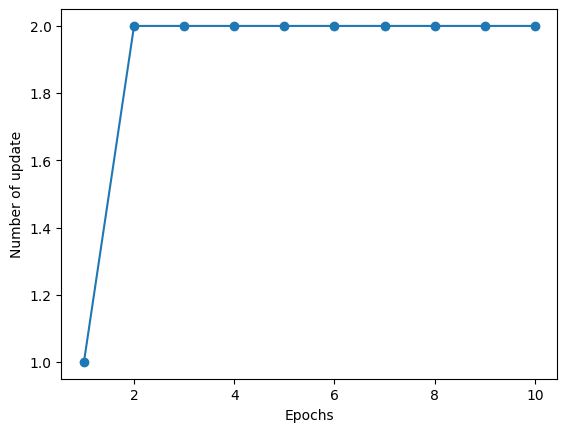

In [25]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X,y) #訓練データへのモデル適合
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of update')
plt.show()

In [44]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier, resolution = 0.02):
    #マーカーとカラーの準備
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','grey','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    #決定領域のプロット
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,0].max() + 1    
    #グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    #各特徴量を1次元配列に配列して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    #予測結果を元にグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    #グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha = 0.3, cmap=cmap) #背景色
    #軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    #クラスごとの訓練データをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0],
                    y = X[y == cl, 1],
                    alpha = 0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = cl,
                    edgecolor='black'
                    )



/var/folders/d4/5zcpv0x10vjbrgcqyd1_90z80000gn/T/ipykernel_63761/3159149658.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x = X[y == cl, 0],


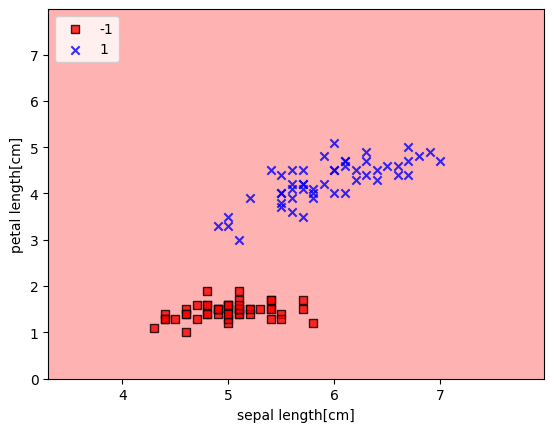

In [45]:
plot_decision_regions(X,y,classifier=ppn)
plt.xlabel('sepal length[cm]')
plt.ylabel('petal length[cm]')
plt.legend(loc='upper left')
plt.show()

In [52]:
#勾配降下法
class AdalineGD(object):
    def __init__(self, eta = 0.01, n_iter=50,random_state=1):
        self.eta = eta #学習率
        self.n_iter = n_iter #訓練データ回数
        self.random_state = random_state #重みを初期化するための乱数シード

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1]) 
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] +=self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self,X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.activation(self.net_input(X)))>=0.0, 1, -1)

<function matplotlib.pyplot.show(close=None, block=None)>

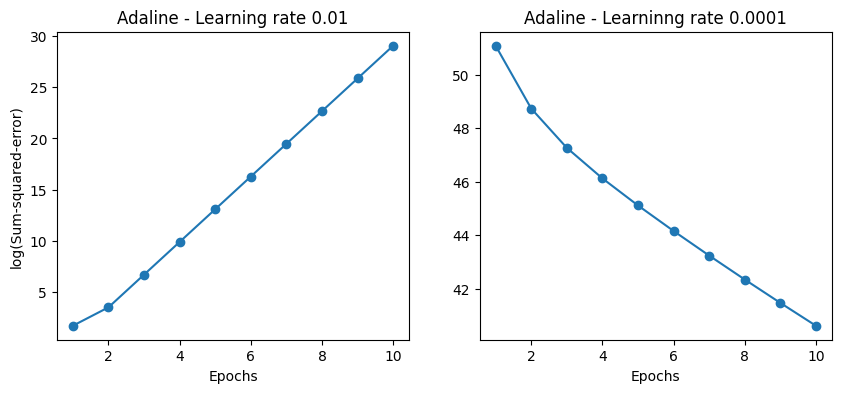

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
adal = AdalineGD(n_iter=10, eta=0.01).fit(X,y)
ax[0].plot(range(1,len(adal.cost_)+1), np.log10(adal.cost_), marker = 'o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')
ada2 = AdalineGD(n_iter = 10, eta = 0.0001).fit(X,y)
ax[1].plot(range(1,len(ada2.cost_)+1), ada2.cost_, marker = 'o')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Adaline - Learninng rate 0.0001')
plt.show

In [58]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

/var/folders/d4/5zcpv0x10vjbrgcqyd1_90z80000gn/T/ipykernel_63761/3159149658.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x = X[y == cl, 0],


<function matplotlib.pyplot.show(close=None, block=None)>

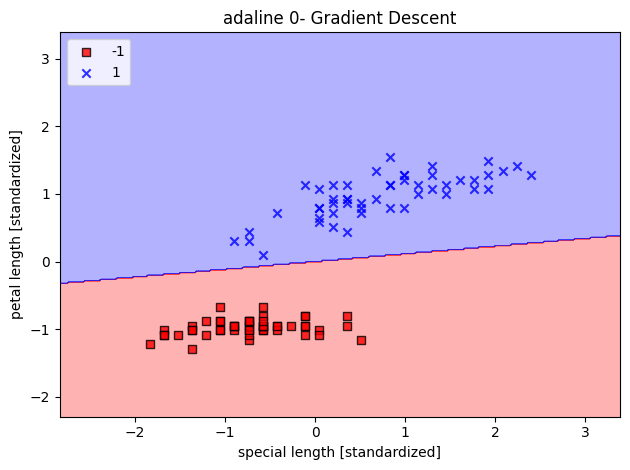

In [60]:
ada_gd = AdalineGD(n_iter=15, eta=0.01)
ada_gd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier = ada_gd)
plt.title('adaline 0- Gradient Descent')
plt.xlabel('special length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

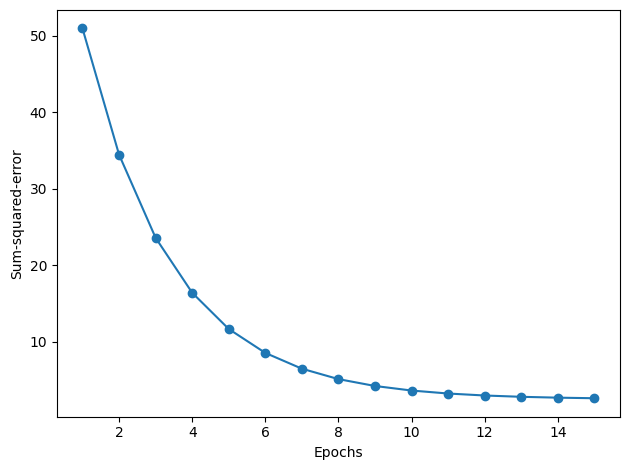

In [61]:
plt.plot(range(1, len(ada_gd.cost_) + 1), ada_gd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show

In [75]:
#確率的勾配法
from numpy.random import seed

class AdalineSGD(object):
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle=shuffle
        self.random_state = random_state

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X,y=self._shuffle(X,y)
            
            cost = []

            for xi, target in zip(X,y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self,X,y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])

        if y.rabel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X,y)
        return self
                

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    


    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initialized = True

    def _update_weights(self, xi ,target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error ** 2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self,X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)        


/var/folders/d4/5zcpv0x10vjbrgcqyd1_90z80000gn/T/ipykernel_63761/3159149658.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x = X[y == cl, 0],


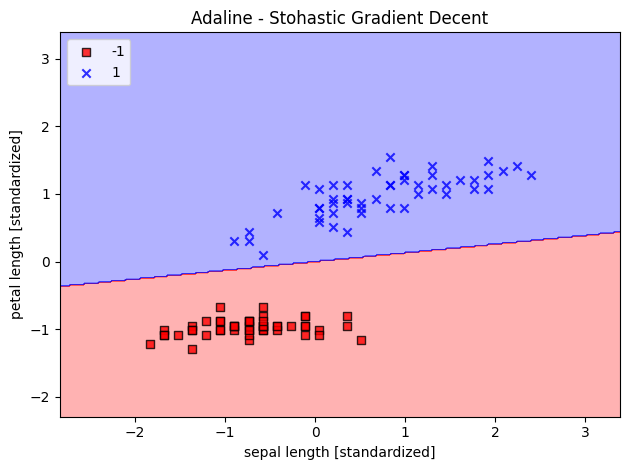

In [76]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stohastic Gradient Decent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()


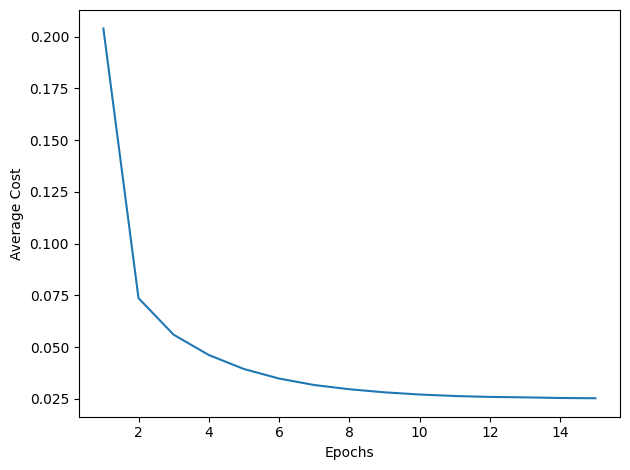

In [78]:
plt.plot(range(1, len(ada_sgd.cost_)+1), ada_sgd.cost_)
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.tight_layout()
plt.show()